In [1]:
import sys
sys.path.append("..")
from flame_analysis_model import *
import torch
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [19]:

comm = MPI.COMM_WORLD
rank = comm.rank

time_step = 120
folder_name = "data/old_phi0.40_h100"#"data/v5"#
file_name = "po_premix"
# Geometry / reference file (constant)

# Communicator for parallelization
comm = MPI.COMM_WORLD

# 2) Load dataset
scalars = [
    'H2','O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
    'curvature', 'stretch_rate', 'disp_speed_density_weighted',
    'abs_flame_prop_vel_normal', 'flow_velocity_normal',
    'flow_velocity_tangential', 'tangential_strain_rate',
    'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
    'vorticity'
]
ds = SEMDataset(file_name=file_name, folder_name= folder_name,time_step= time_step, comm=MPI.COMM_WORLD, scalar_names=scalars)
df = ds.create_dataframe(
    compute_vel_jacobian= False,
    compute_vel_hessian= False,
    compute_reaction_rates= True,
    cantera_inputs = ["BurkeH2.yaml", None, 0.5, 300, 5e05]


)
print(ds.x.shape)
print(ds.x.size)

print(ds.x.reshape(-1).shape)
print(ds.x.reshape(-1).size)

2025-11-25 15:16:41,472 - Mesh - INFO - Initializing empty Mesh object.
2025-11-25 15:16:41,474 - Field - INFO - Initializing empty Field object
2025-11-25 15:16:41,478 - pynekread - INFO - Reading file: ./data/old_phi0.40_h100/po_premix0.f00001
2025-11-25 15:16:41,528 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-11-25 15:16:41,529 - Mesh - INFO - Initializing common attributes.
2025-11-25 15:16:41,531 - Mesh - INFO - Getting vertices
2025-11-25 15:16:41,537 - Mesh - INFO - Getting edge centers
2025-11-25 15:16:41,601 - Mesh - INFO - Facet centers not available for 2D
2025-11-25 15:16:41,602 - Mesh - INFO - Mesh object initialized.
2025-11-25 15:16:41,602 - Mesh - INFO - Mesh data is of type: float64
2025-11-25 15:16:41,603 - Mesh - INFO - Elapsed time: 0.07465359999332577s
2025-11-25 15:16:41,603 - pynekread - INFO - Reading field data
2025-11-25 15:16:41,604 - pynekread - INFO - Overwriting fld object
2025-11-25 15:16:42,197 - pynekread - INFO - File read
2025-1

In [4]:
from pysemtools.postprocessing.plotting import isosurfaces
# Build mesh dict exactly as the function expects
mesh_dict = {
    "x": ds.x.reshape(-1),
    "y": ds.y.reshape(-1),
    "z": ds.z.reshape(-1),
}

# Choose which field(s) you want isosurfaces for – here: temperature T
fields_dict = {
    "T": ds.t.reshape(-1),   # same shape as mesh coords
}
print(ds.t.shape)
# Define the isosurface levels for each field
isos_dict = {
    "T": np.array([3.5, 3.8, 4.0, 4.5, 5.0]),
}

# Call the pySEMtools helper
plotters = isosurfaces(
    mesh=mesh_dict,
    fields=fields_dict,
    isosurfaces=isos_dict,
    shape=(1, len(isos_dict["T"])),
    colormap="viridis",
    opacity=1.0,
)

# Show each plotter (depending on how you run your code)
for pl in plotters:
    pl.show()


(42780, 1, 8, 8)


Widget(value='<iframe src="http://localhost:59223/index.html?ui=P_0x1e6f0921e80_0&reconnect=auto" class="pyvis…

In [5]:

front = ds.extract_flame_front_pyvista(
    sample_mode= "isocontour",
    c_level= 3.5,
)
print(front)
print("Extarcted flame front")
front.to_csv(f"extracted_flame_front_{time_step}.csv", index=False)

               x          y    z    T        H2        O2       H2O  \
0     345.108456  50.186360  0.0  3.5  0.000040  0.176700  0.069967   
1     345.073181  50.548154  0.0  3.5  0.000040  0.176690  0.069959   
2     345.013631  50.376839  0.0  3.5  0.000041  0.176665  0.069920   
3     344.961395  50.664563  0.0  3.5  0.000041  0.176657  0.069901   
4     344.942186  50.503932  0.0  3.5  0.000041  0.176646  0.069885   
...          ...        ...  ...  ...       ...       ...       ...   
4094  283.278910  20.916025  0.0  3.5  0.002246  0.170866  0.071377   
4095  283.336763  20.816735  0.0  3.5  0.002404  0.167928  0.072556   
4096  283.344117  20.803104  0.0  3.5  0.002233  0.170710  0.071465   
4097  283.432331  20.649066  0.0  3.5  0.002220  0.170932  0.071374   
4098  283.432519  20.648911  0.0  3.5  0.002218  0.170952  0.071367   

                 H         O        OH  ...  stretch_rate  \
0     5.354853e-08  0.000007  0.000022  ...     -5.507097   
1     5.499092e-08  0.000

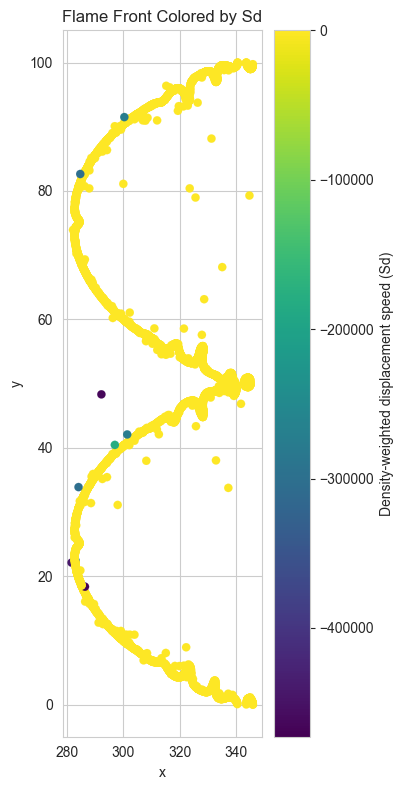

In [6]:
plt.figure(figsize=(4, 8))

sc = plt.scatter(
    front["x"],
    front["y"],
    c = front["disp_speed_density_weighted"],
    cmap = "viridis",
    linewidths = 0.1
)


plt.colorbar(sc, label="Density-weighted displacement speed (Sd)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Flame Front Colored by Sd")

plt.tight_layout()
plt.show()


In [7]:
print(df.head())
print(df.dtypes)

# Missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Basic stats
print("\nDescribe numeric columns:")
print(df.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))



            x          y          u         v         T            H2  \
0  372.854279  83.870964  16.479141  0.008415  4.885574  1.060885e-07   
1  372.803101  83.870964  16.479160  0.007721  4.885702  1.062000e-07   
2  372.691284  83.870964  16.479170  0.006219  4.885983  1.064450e-07   
3  372.538635  83.870964  16.479120  0.004201  4.886373  1.067826e-07   
4  372.371552  83.870964  16.478975  0.002038  4.886804  1.071560e-07   

         O2       H2O             H         O  ...       omega_H2  \
0  0.134942  0.106703  1.326374e-09  0.000001  ...  258358.267558   
1  0.134938  0.106706  1.328348e-09  0.000001  ...  259004.527417   
2  0.134929  0.106714  1.332683e-09  0.000001  ...  260411.794678   
3  0.134916  0.106724  1.338656e-09  0.000001  ...  262335.615546   
4  0.134903  0.106735  1.345262e-09  0.000001  ...  264444.349800   

       omega_O2     omega_H2O       omega_H       omega_O      omega_OH  \
0 -7.062659e+09  5.931686e+09 -1.322707e+10 -3.903731e+08 -1.255537e+10

In [8]:

print(front.head())
print(front.dtypes)

# Missing values
print("\nMissing values per column:")
print(front.isna().sum())

# Basic stats
print("\nDescribe numeric columns:")
print(front.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

            x          y    z    T        H2        O2       H2O  \
0  345.108456  50.186360  0.0  3.5  0.000040  0.176700  0.069967   
1  345.073181  50.548154  0.0  3.5  0.000040  0.176690  0.069959   
2  345.013631  50.376839  0.0  3.5  0.000041  0.176665  0.069920   
3  344.961395  50.664563  0.0  3.5  0.000041  0.176657  0.069901   
4  344.942186  50.503932  0.0  3.5  0.000041  0.176646  0.069885   

              H         O        OH  ...  stretch_rate  \
0  5.354853e-08  0.000007  0.000022  ...     -5.507097   
1  5.499092e-08  0.000007  0.000022  ...     -3.887922   
2  5.680861e-08  0.000007  0.000023  ...     -5.112473   
3  5.829312e-08  0.000007  0.000022  ...     -3.008751   
4  5.903063e-08  0.000007  0.000023  ...     -4.487560   

   disp_speed_density_weighted  abs_flame_prop_vel_normal  \
0                     1.027138                  -4.773535   
1                     0.937513                  -4.369076   
2                     0.998732                  -3.991068  

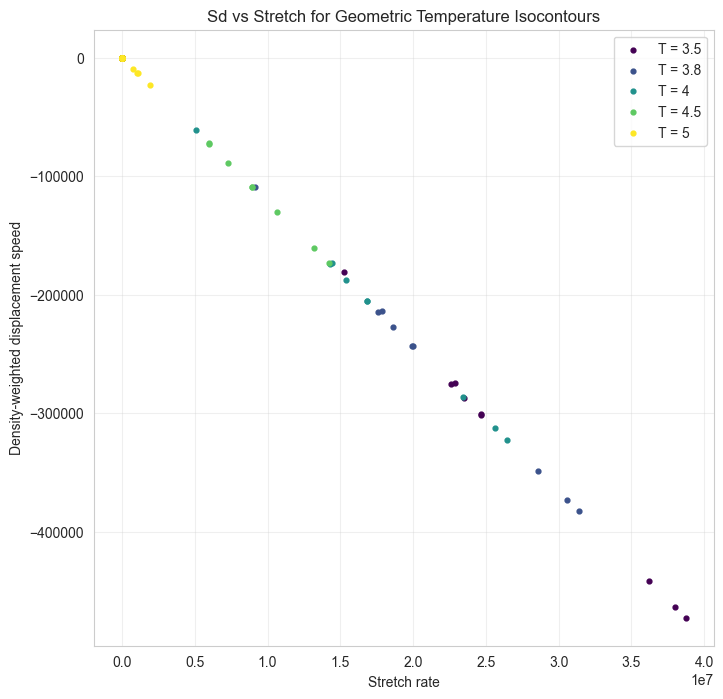

In [53]:
isocon_list = [ 3.5, 3.8, 4, 4.5, 5]

plt.figure(figsize=(8, 8))

cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(isocon_list)))

for i, iso in enumerate(isocon_list):

    # Extract the flame front for this isocontour
    isoline = ds.extract_flame_front_pyvista(
        sample_mode="isocontour",
        c_level=iso,
    )

    x = isoline["stretch_rate"].to_numpy()
    y = isoline["disp_speed_density_weighted"].to_numpy()

    plt.scatter(x, y, s=12, color=colors[i], label=f"T = {iso}")

    # Fit a line if possible
    # if len(x) > 2:
    #     coeffs = np.polyfit(x, y, deg=1)
    #     x_line = np.linspace(x.min(), x.max(), 200)
    #     y_line = coeffs[0] * x_line + coeffs[1]
    #     plt.plot(x_line, y_line, color=colors[i], linewidth=2)

plt.xlabel("Stretch rate")
plt.ylabel("Density-weighted displacement speed")
# plt.ylim((-5, 5))
# plt.xlim((-200,200))
plt.title("Sd vs Stretch for Geometric Temperature Isocontours")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


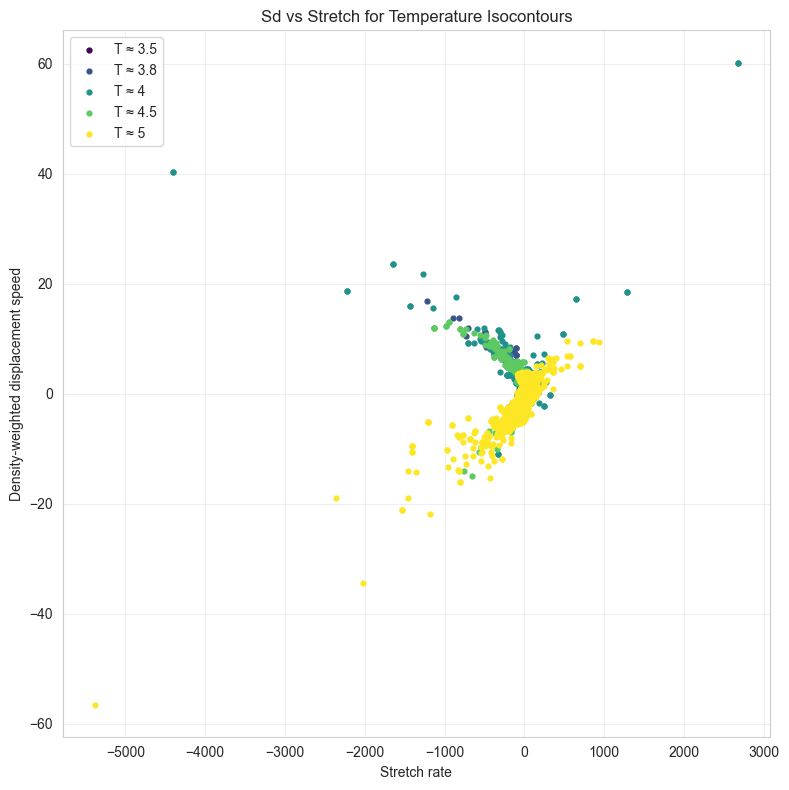

In [54]:
isocon_list = [ 3.5, 3.8, 4, 4.5, 5]
tol = 0.1

plt.figure(figsize=(8, 8))

cmap = plt.cm.viridis  # choose your preferred colormap
colors = cmap(np.linspace(0, 1, len(isocon_list)))

for i, iso in enumerate(isocon_list):
    # Select iso-line slice
    iso_df = df[(df["T"] > (iso - tol)) & (df["T"] < (iso + tol))]

    x = iso_df["stretch_rate"].to_numpy()
    y = iso_df["disp_speed_density_weighted"].to_numpy()

    # Scatter plot
    plt.scatter(x, y, s=12, color=colors[i], label=f"T ≈ {iso}")

plt.xlabel("Stretch rate")
plt.ylabel("Density-weighted displacement speed")
plt.title("Sd vs Stretch for Temperature Isocontours")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




In [24]:
front_old = ds.extract_flame_front_old(
    sample_mode= "progress",
    c_level= 0.51,
    tol= 0.35
)
print(front_old)
print("Extarcted flame front")
front_old.to_csv(f"extracted_flame_front_{time_step}.csv", index=False)

                  x          y          u         v         T            H2  \
11127    364.123047  95.967743  10.487868 -0.128807  4.426628  1.000297e-07   
11135    364.071869  95.967743  10.486437 -0.129190  4.426384  1.004250e-07   
11194    363.436432  95.967743  10.469288 -0.131331  4.426653  1.059165e-07   
11195    363.589111  95.967743  10.473248 -0.131218  4.426034  1.044985e-07   
11196    363.756195  95.967743  10.477721 -0.130821  4.425757  1.030176e-07   
...             ...        ...        ...       ...       ...           ...   
1315633  283.381927  20.213009   2.861038 -1.043504  2.143348  4.865834e-03   
1315634  283.270142  20.213009   2.347739 -1.267220  1.737864  5.873242e-03   
1315640  283.433136  20.161291   2.964994 -0.999817  2.214789  4.703499e-03   
1315641  283.381927  20.161291   2.712486 -1.118868  2.012505  5.158657e-03   
1315642  283.270142  20.161291   2.240086 -1.320497  1.639641  6.161300e-03   

               O2       H2O             H          

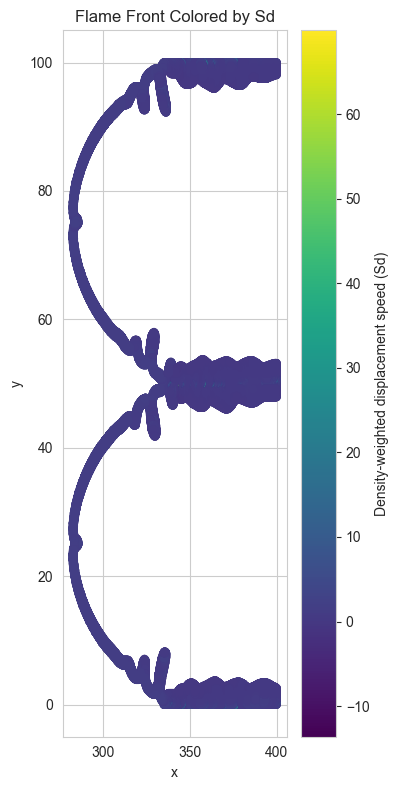

In [28]:
plt.figure(figsize=(4, 8))

sc = plt.scatter(
    front_old["x"],
    front_old["y"],
    c = front_old["disp_speed_density_weighted"],
    cmap = "viridis",
    linewidths = 0.1
)


plt.colorbar(sc, label="Density-weighted displacement speed (Sd)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Flame Front Colored by Sd")
plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
num_cols = df.select_dtypes(include='number').columns.intersection(
    front.select_dtypes(include='number').columns
)

desc_df    = front[num_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])
desc_front = front_old[num_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])

# Put them side-by-side
desc_both = pd.concat(
    {'front': desc_df, 'front_old': desc_front},
    axis=1
)

print(desc_both)


             front                                                       \
                 x            y             T           H2           O2   
count  4099.000000  4099.000000  4.099000e+03  4099.000000  4099.000000   
mean    310.795633    50.174180  3.500000e+00     0.001820     0.170606   
std      18.907244    30.724066  1.105608e-16     0.000683     0.002585   
min     281.579419     0.000000  3.500000e+00     0.000039     0.160502   
1%      282.685871     0.834385  3.500000e+00     0.000043     0.163919   
5%      283.302564     2.408846  3.500000e+00     0.000325     0.166100   
50%     310.681946    49.801762  3.500000e+00     0.001910     0.170927   
95%     339.956757    98.168351  3.500000e+00     0.002612     0.175781   
99%     345.105725    99.489594  3.500000e+00     0.004082     0.176645   
max     345.965608   100.000000  3.500000e+00     0.004543     0.177035   

                                                                          ...  \
               H2O